In [44]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score, make_scorer
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from utils.general_utils import save_model
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
import imblearn
from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA



from utils.general_utils import get_outlier_info, get_outlier_val_counts, clean_outliers
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 

In [2]:
from scipy import stats

In [3]:
datasetv2_save_path = "dataset/dataset_v2"
imputed_df = pd.read_csv(f'{datasetv2_save_path}/imputed_df.csv', index_col=0)
imputed_df.head()

,pcr,rfs,Age,ER,PgR,LNStatus,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,ChemoGrade_1.0,ChemoGrade_2.0,ChemoGrade_3.0,Proliferation_1.0,Proliferation_2.0,Proliferation_3.0,TumourStage_1.0,TumourStage_2.0,TumourStage_3.0,TumourStage_4.0
0,1.0,144.0,41.0,0.0,0.0,1.0,0.813912,0.724080,23.781937,32.844370,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,142.0,39.0,1.0,1.0,1.0,0.666118,0.476173,20.715461,43.504095,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,135.0,31.0,0.0,0.0,0.0,0.645083,0.594470,21.659822,36.435505,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,12.0,35.0,0.0,0.0,1.0,0.770842,0.501228,26.590504,53.050724,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,109.0,61.0,1.0,0.0,0.0,0.861035,0.750267,20.456571,27.265716,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
train, test = train_test_split(imputed_df, test_size=0.20)

In [20]:
multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus'] + multi_category_variables

continous_features_labels = imputed_df.drop(columns=categorical_features_labels+['pcr', 'rfs']).columns

In [21]:
train_continous_feature_array = train[continous_features_labels].to_numpy()

test_continous_feature_array = test[continous_features_labels].to_numpy()

In [22]:
# scalerTrainX = StandardScaler()
# scalerTrainY = StandardScaler()
# scalerTrainX = RobustScaler()
# scalerTrainY = RobustScaler()

scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


train_cont_X = scalerTrainX.fit_transform(train_continous_feature_array)
train_cat_X = train[categorical_features_labels].to_numpy()
trainX = np.hstack((train_cat_X, train_cont_X))
                   
trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))

                   
test_cont_X = scalerTrainX.transform(test_continous_feature_array)
test_cat_X = test[categorical_features_labels].to_numpy()
testX = np.hstack((test_cat_X, test_cont_X))
                   
testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))


In [23]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((320, 60), (320, 1), (80, 60), (80, 1))

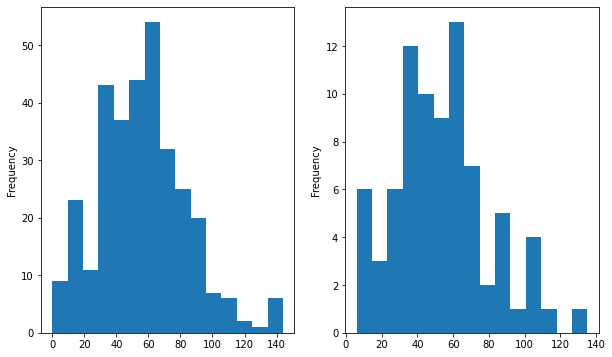

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10, 6))

train['rfs'].plot(kind='hist', bins=15, ax=axes[0])
test['rfs'].plot(kind='hist', bins=15, ax=axes[1])

plt.show()

In [25]:
best_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': 10,
 'max_features': 20,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [26]:
regressor = RandomForestRegressor(**best_params)
regressor.fit(trainX, trainY.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=10, max_features=20,
                      min_samples_leaf=4, min_samples_split=5, random_state=0)

Mean Absolute Error (MAE):

MAE measures the average absolute difference between the predicted and actual values. It gives you an idea of the average magnitude of errors in your predictions.
MAE is scale-dependent, meaning its value is in the same unit as the target variable. Therefore, the interpretation of whether an MAE of 0.15 is good or bad depends on the scale of your target variable.

In [41]:
predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.03062291176576628
MAE error: 0.1431936487267361
R2 error: 0.07483434585817372


In [35]:
testY.shape

(80, 1)

In [37]:
pred_inverse_norm_vals = scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten()
gt_inverse_norm_vals = scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten()

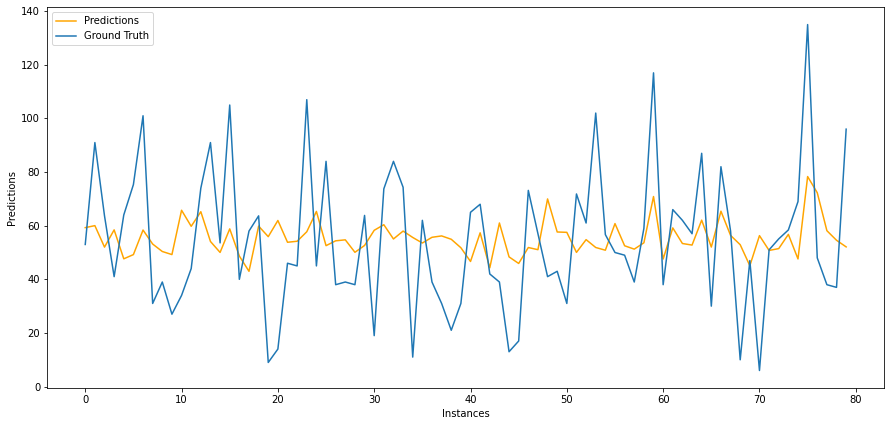

In [36]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

In [38]:
# Define a dictionary containing Students data
data = {'GT': gt_inverse_norm_vals,
        'Predictions': pred_inverse_norm_vals}
 
# Convert the dictionary into DataFrame
df = pd.DataFrame(data)
 

In [39]:
df

,GT,Predictions
0,53.000000,59.279167
1,91.000000,60.023333
2,63.666667,52.017083
3,41.000000,58.444583
4,64.000000,47.650833
...,...,...
75,135.000000,78.325417
76,48.000000,72.291667
77,38.000000,58.135000
78,37.000000,54.567083


# Training a MLP model


In [52]:
# regrMLP  = MLPRegressor(random_state=1, solver='sgd', early_stopping=True, max_iter=200, learning_rate='adaptive', verbose=True, hidden_layer_sizes=10, batch_size=8)

In [45]:
regrMLP  = MLPRegressor(random_state=1, batch_size=8)

In [53]:
regrMLP.fit(trainX, trainY.ravel())

Iteration 1, loss = 0.09026245
Validation score: -3.330860
Iteration 2, loss = 0.05777524
Validation score: -2.006131
Iteration 3, loss = 0.04540478
Validation score: -1.295854
Iteration 4, loss = 0.03953334
Validation score: -0.953753
Iteration 5, loss = 0.03596757
Validation score: -0.741324
Iteration 6, loss = 0.03337523
Validation score: -0.613800
Iteration 7, loss = 0.03156230
Validation score: -0.495858
Iteration 8, loss = 0.03007995
Validation score: -0.452392
Iteration 9, loss = 0.02902482
Validation score: -0.343097
Iteration 10, loss = 0.02790203
Validation score: -0.356324
Iteration 11, loss = 0.02705949
Validation score: -0.248620
Iteration 12, loss = 0.02650377
Validation score: -0.231916
Iteration 13, loss = 0.02574518
Validation score: -0.203173
Iteration 14, loss = 0.02523148
Validation score: -0.187615
Iteration 15, loss = 0.02488747
Validation score: -0.135791
Iteration 16, loss = 0.02441787
Validation score: -0.165517
Iteration 17, loss = 0.02400302
Validation score:

MLPRegressor(batch_size=8, early_stopping=True, hidden_layer_sizes=10,
             learning_rate='adaptive', random_state=1, solver='sgd',
             verbose=True)

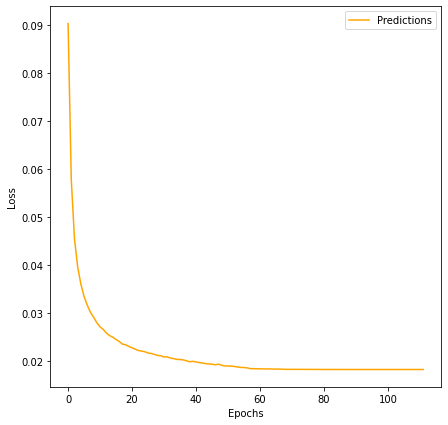

In [54]:
plt.figure(figsize=(7,7))
plt.plot(list(range(len(regrMLP.loss_curve_))), regrMLP.loss_curve_, color='orange', label='Predictions')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

In [55]:
predicted = regrMLP.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.03736115265104821
MAE error: 0.15707722623453013
R2 error: -0.1287383608811674


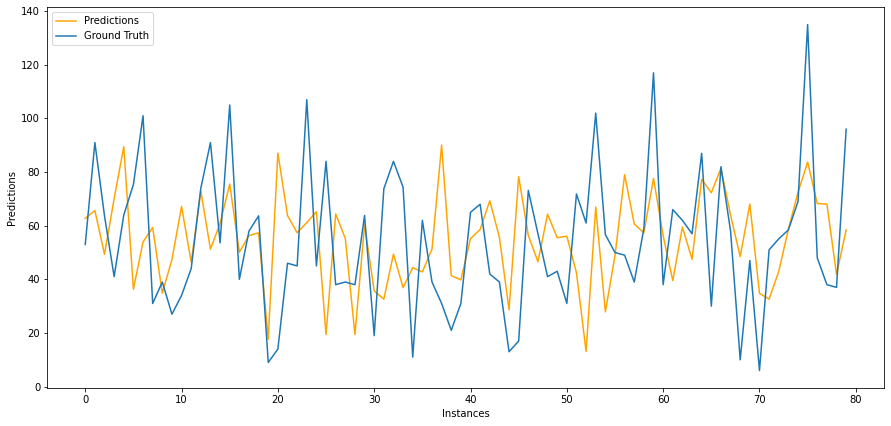

In [56]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# Gridsearch for MLP

In [57]:
hidden_layer_sizes = [9, 12, 18, 20]
activation = ['logistic', 'tanh', 'relu']
solver = ['sgd', 'adam']
batch_size = [8, 16]
learning_rate = ['adaptive', 'invscaling', 'constant']
max_iter = [100, 150, 200, 250]
early_stopping=[True]

parameters = dict(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver,
                  batch_size=batch_size, learning_rate=learning_rate,
                  max_iter=max_iter, early_stopping=early_stopping)

In [58]:
regrMLP  = MLPRegressor()
regrMLP_GS = GridSearchCV(regrMLP, parameters)
regrMLP_GS.fit(trainX, trainY.ravel())

C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multi

GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': [8, 16], 'early_stopping': [True],
                         'hidden_layer_sizes': [9, 12, 18, 20],
                         'learning_rate': ['adaptive', 'invscaling',
                                           'constant'],
                         'max_iter': [100, 150, 200, 250],
                         'solver': ['sgd', 'adam']})

In [59]:
regrMLP_GS.best_estimator_.get_params() 

{'activation': 'logistic',
 'alpha': 0.0001,
 'batch_size': 8,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 12,
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [61]:
regrMLP  = MLPRegressor(**regrMLP_GS.best_estimator_.get_params() )
regrMLP.fit(trainX, trainY.ravel())

MLPRegressor(activation='logistic', batch_size=8, early_stopping=True,
             hidden_layer_sizes=12, learning_rate='invscaling', solver='sgd')

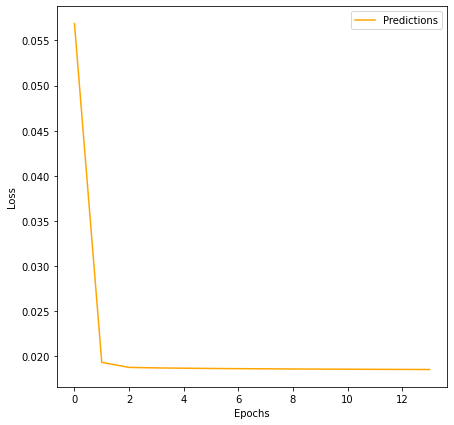

In [62]:
plt.figure(figsize=(7,7))
plt.plot(list(range(len(regrMLP.loss_curve_))), regrMLP.loss_curve_, color='orange', label='Predictions')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

In [63]:
predicted = regrMLP.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.034035909454626145
MAE error: 0.1439480346008955
R2 error: -0.02827760716415395


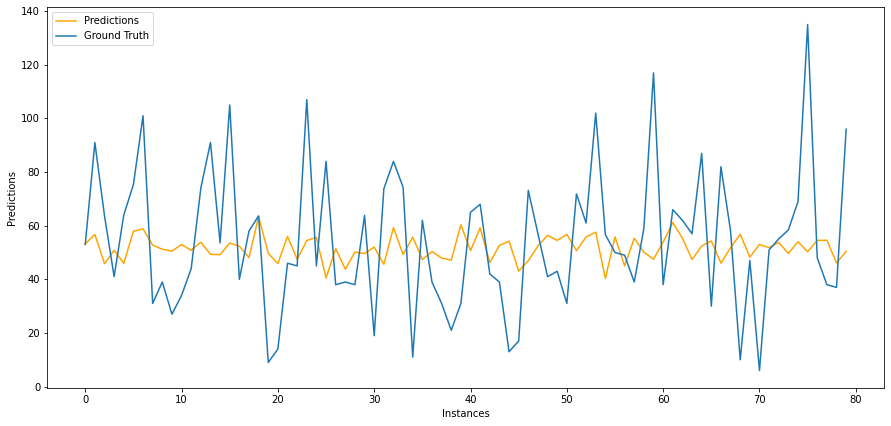

In [64]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

In [69]:
# Calculate residuals
residuals = testY.ravel() - predicted

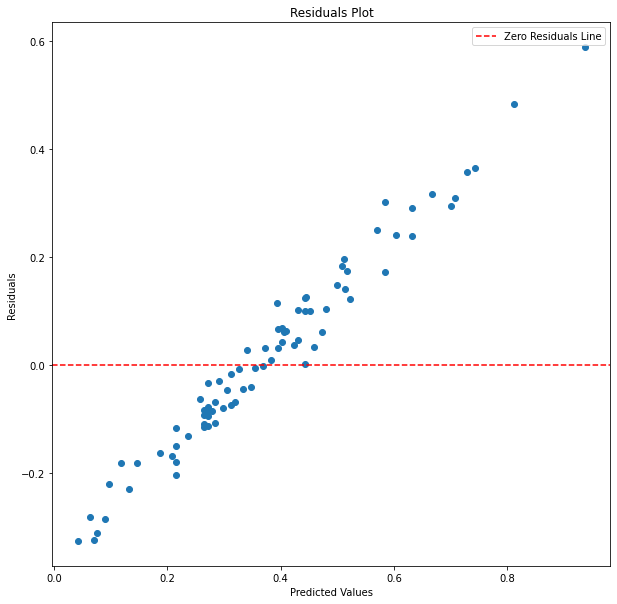

In [74]:
# Plot residuals
plt.figure(figsize=(10,10))
plt.scatter(testY.ravel(), residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Residuals Line")
plt.legend()
plt.show()